In [28]:
import re
import pandas as pd
from typing import List, Union
import ast


def calculate_accuracy(true_answers, pred_answers):
    correct = 0
    total = len(true_answers)

    def extract_answer(text):
        if isinstance(text, str):
            match = re.search(r'answer\s*:\s*([a-zA-Z]+(\s+[a-zA-Z]+)?(\s+[a-zA-Z]+)?)', text, re.IGNORECASE)
            if match:
                return match.group(1).strip()
        return text  # Return the original text if no match is found or if it's not a string

    def normalize_answer(answer):
        if isinstance(answer, str):
            # First, try to extract the answer if it's in the format "answer: ..."
            answer = extract_answer(answer)
            # Then, try to evaluate if it's a string representation of a list
            try:
                answer = ast.literal_eval(answer)
            except:
                pass
        
        if isinstance(answer, list):
            return [str(item).lower().strip() for item in answer]
        else:
            return [str(answer).lower().strip()]

    for true, pred in zip(true_answers, pred_answers):
        if pd.isna(true) or pd.isna(pred):
            total -= 1  # Skip this pair if either is NaN
            continue

        true_set = set(normalize_answer(true))
        pred_set = set(normalize_answer(pred))

        if len(true_set) > 1:  # Multiple correct answers
            if true_set == pred_set:
                 correct += 1  # Full match
            elif true_set.intersection(pred_set):
                correct += 0.5  # Partial match
        else:  # Single correct answer
            if true_set == pred_set:
                correct += 1

    return correct / total if total > 0 else 0




In [22]:
def calculate_accuracy_new(true_answers, pred_answers):
    correct = 0
    total = len(true_answers)

    def extract_answer(text):
        
        # Match "the answer is" or "answer" followed by any text
        match = re.search(r"(?:the answer is|answer)(?:\s*:?\s*)(.+)", text, re.IGNORECASE) #([^.]+)(?:\.|$)"
        if match:
                text = match.group(1).strip()
                # Check if the text begins with "yes" or "no" and is longer than one word
        yes_no_match = re.match(r'^(yes|no)\b', text, re.IGNORECASE)
        if yes_no_match:
                text= yes_no_match.group(1).lower()
        return text
    
    def normalize_answer(answer):
        answer = extract_answer(answer)
        if isinstance(answer, str):
        # Then, try to evaluate if it's a string representation of a list
            try:
                lst = ast.literal_eval(answer)
            # Join list elements into a single string, remove special characters, and strip
                return [re.sub(r'[^\w\s]', ' ', ','.join(str(item) for item in lst)).strip().lower()]
            except:
                pass

        if isinstance(answer, list):
           return [re.sub(r'[^\w\s]', ' ', str(item)).strip().lower() for item in answer]
        else:
           return [re.sub(r'[^\w\s]', ' ', str(answer)).strip().lower()]
    

    for true, pred in zip(true_answers, pred_answers):
        if pd.isna(true) or pd.isna(pred):
            total -= 1  # Skip this pair if either is NaN
            continue

        true_set = set(normalize_answer(true))
        pred_set = set(normalize_answer(pred))

        if len(true_set) > 1:  # Multiple correct answers
            if true_set == pred_set:
                correct += 1  # Full match
            elif true_set.intersection(pred_set):
                correct += 0.4  # Partial match
        else:  # Single correct answer
            if true_set == pred_set:
                correct += 1

    return correct / total if total > 0 else 0

In [19]:
import re
import pandas as pd


def extract_answer(text):
        
        # Match "the answer is" or "answer" followed by any text
        match = re.search(r"(?:the answer is|answer)(?:\s*:?\s*)(.+)", text, re.IGNORECASE) #([^.]+)(?:\.|$)"
        if match:
                text = match.group(1).strip()
                # Check if the text begins with "yes" or "no" and is longer than one word
        yes_no_match = re.match(r'^(yes|no)\b', text, re.IGNORECASE)
        if yes_no_match:
                text= yes_no_match.group(1).lower()
        return text


# Load the CSV file
df = pd.read_csv('5_ollama_models_Base.csv')


# Apply the extract_answer function to the "ollama/gemma:2b" column and replace the original column
df["ollama/gemma:2b"] = df["ollama/gemma:2b"].apply(extract_answer)


# Save the updated DataFrame back to CSV
df.to_csv('5_ollama_models_Base.csv', index=False)
print("\nUpdated CSV saved as '5_ollama_models_Base_full_updated.csv'")


Updated CSV saved as '5_ollama_models_Base_full_updated.csv'


In [21]:
import pandas as pd

# Read the two CSV files
df2= pd.read_csv('5_ollama_models_Base.csv')
df1 = pd.read_csv('5_ollama_models_Base_full.csv')


# Concatenate the dataframes based on the 'Question' column
result = pd.concat([df1, df2], axis=0, ignore_index=True)

# Remove duplicate rows based on the 'Question' column, keeping the first occurrence
result = result.drop_duplicates(subset='Question', keep='first')

# Reset the index of the resulting dataframe
result = result.reset_index(drop=True)
relation_counts = result ['Q_type'].value_counts()
print(relation_counts)
# Save the result to a new CSV file
result.to_csv('5_ollamam_models_base_combined.csv', index=False)

print(f"Combined CSV file created with {len(result)} rows.")


Q_type
YN    84
FR    55
CO    43
FB    35
Name: count, dtype: int64
Combined CSV file created with 217 rows.


In [1]:
import pandas as pd
import ast
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_accuracy_transformer(true_answers: pd.Series, pred_answers: pd.Series) -> float:
    # Load a pre-trained sentence transformer model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    def normalize(answer):
        if pd.isna(answer):
            return ""
        # Try to evaluate as a literal Python expression (for list-like strings)
        try:
            answer_list = ast.literal_eval(answer)
            if isinstance(answer_list, list):
                return ", ".join(str(item).strip() for item in answer_list)
        except:
            pass
        
        # If not a list, return as is
        return str(answer).strip()

    def compute_similarity(true, pred):
        # Encode sentences
        true_embedding = model.encode([true])
        pred_embedding = model.encode([pred])
        
        # Compute cosine similarity
        similarity = cosine_similarity(true_embedding, pred_embedding)[0][0]
        
        # Adjust similarity score to consider partial matches
        if similarity > 0.9:  # High similarity, consider as full match
            return 1.0
        elif similarity > 0.7:  # Moderate similarity, consider as partial match
            return 0.5
        else:
            return similarity  # Low similarity, return as is

    total_similarity = 0
    valid_comparisons = 0

    for true, pred in zip(true_answers, pred_answers):
        true_normalized = normalize(true)
        pred_normalized = normalize(pred)

        if not true_normalized or not pred_normalized:
            continue

        similarity = compute_similarity(true_normalized, pred_normalized)
        total_similarity += similarity
        valid_comparisons += 1

    accuracy = total_similarity / valid_comparisons if valid_comparisons > 0 else 0.0

    return accuracy


/opt/miniconda3/envs/autogen/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Q_type Dictionary {'YN': 36, 'CO': 23, 'FR': 21, 'FB': 20}
{'ollama/gemma:2b': 0.3225806451612903, 'ollama/phi3:mini': 0.3317972350230415, 'ollama/openchat': 0.3640552995391705, 'ollama/llama3': 0.39631336405529954, 'ollama/mistral': 0.3548387096774194}
Accuracy by Q_type for each model:

ollama/gemma:2b:
  CO: 0.2558
  FB: 0.3714
  FR: 0.0000
  YN: 0.5476

ollama/phi3:mini:
  CO: 0.1628
  FB: 0.5429
  FR: 0.0182
  YN: 0.5357

ollama/openchat:
  CO: 0.3488
  FB: 0.5429
  FR: 0.0545
  YN: 0.5000

ollama/llama3:
  CO: 0.3721
  FB: 0.5429
  FR: 0.0182
  YN: 0.5952

ollama/mistral:
  CO: 0.2558
  FB: 0.4286
  FR: 0.0727
  YN: 0.5595

Overall metrics:
ollama/gemma:2b: 0.3226
ollama/phi3:mini: 0.3318
ollama/openchat: 0.3641
ollama/llama3: 0.3963
ollama/mistral: 0.3548


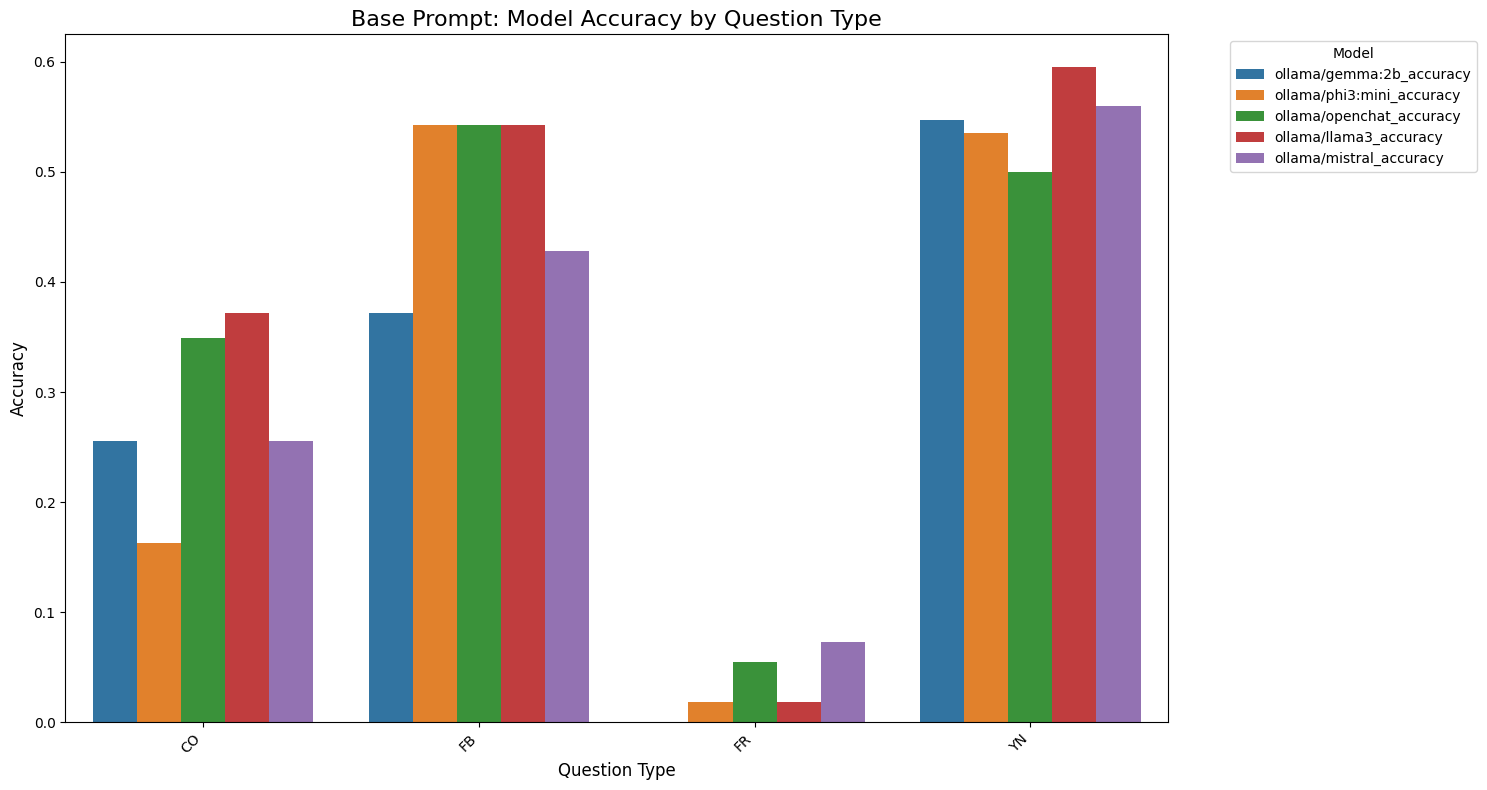

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df_results = pd.read_csv('5_ollamam_models_base_combined.csv')
relations = df['Q_type'].unique()
# Get the unique relations and their counts
relation_counts = df['Q_type'].value_counts()
# Create a dictionary of relations
relation_dict = relation_counts.to_dict()
# Print the relation dictionary
print("Q_type Dictionary",relation_dict)


models = ["ollama/gemma:2b","ollama/phi3:mini","ollama/openchat", "ollama/llama3","ollama/mistral"]
metrics = {}
for model in models:
    column_name = f'{model}_accuracy'
    df_results[column_name] = df_results.apply(lambda row: calculate_accuracy_new([row['Answer']], [row[model]]), axis=1)

    metrics[model] = df_results[column_name].mean()
    
df_results.to_csv('5_ollamam_models_base_accuracy.csv', index=False)

print(metrics)
# Group by Q_type and calculate mean accuracy for each model
accuracy_by_qtype = df_results.groupby('Q_type')[[f'{model}_accuracy' for model in models]].mean().reset_index()
# Print accuracy by Q_type for each model
print("Accuracy by Q_type for each model:")
for model in models:
    print(f"\n{model}:")
    for _, row in accuracy_by_qtype.iterrows():
        q_type = row['Q_type']
        accuracy = row[f'{model}_accuracy']
        print(f"  {q_type}: {accuracy:.4f}")

# Print overall metrics
print("\nOverall metrics:")
for model, accuracy in metrics.items():
    print(f"{model}: {accuracy:.4f}")
# Rename columns for better readability
# accuracy_by_qtype.columns = ['Q_type'] + models

# Melt the dataframe for easier plotting with Seaborn
melted_df = accuracy_by_qtype.melt(id_vars='Q_type', var_name='Model', value_name='Accuracy')

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(data=melted_df, x='Q_type', y='Accuracy', hue='Model')
plt.title('Base Prompt: Model Accuracy by Question Type', fontsize=16)
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df_results = pd.read_csv('5_ollama_models_Base_full_updated.csv')

models = ["ollama/openchat", "ollama/llama3","ollama/mistral","ollama/phi3:mini","ollama/gemma:2b"]
metrics = {}
for model in models:
    accuracy = calculate_accuracy_1(df_results['Answer'], df_results[model])
    metrics[model] = {'accuracy': accuracy}
metrics_df = pd.DataFrame(metrics).T
print("metrics for Base prompt", metrics_df)
